데이터: STL-10을 torchvision에서 자동 다운로드(Stanford 호스팅 tar.gz 원본 경로 및 파라미터는 공식 문서/소스에 명시). 224 해상도로 리사이즈, 표준 Normalize, 기본/강한 증강 두 가지 파이프라인 제공.

모델: 순수 PyTorch로 Vision Transformer를 구현한다(패치 임베딩 Conv2d 방식, CLS 토큰+포지셔널 임베딩, MHA, FFN, Residual/LN, Encoder 쌓기, 평균 풀 헤드도 옵션). 참고용 구현 레퍼런스는 공개 ViT 구현 및 튜토리얼 자료.

학습: CrossEntropyLoss, AdamW, CosineAnnealingWarmRestarts, torchmetrics Accuracy/F1, tqdm로 실시간 미니배치/에폭 로깅.

In [2]:
# 최신/안정 버전 설치
# Colab에서는 일부가 사전 탑재되어 있을 수 있으나, 버전 최신화를 위해 재설치 가능
# !pip -q install --upgrade torch torchvision torchmetrics einops tqdm
# !pip -q install --upgrade torchmetrics

import os, math, time, random, copy
import numpy as np
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms, utils

from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce

from tqdm import tqdm
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
print("Torch:", torch.__version__, "Torchvision:", torchvision.__version__)


Device: cuda
Torch: 2.8.0+cu126 Torchvision: 0.23.0+cu126


최신 라이브러리 설치 및 기본 임포트. 학습 로그를 깔끔하게 보기 위해 tqdm을 사용하고, 메트릭은 torchmetrics로 계산한다.

In [3]:
# 데이터 루트
data_root = './data'

# 변환 정의: 기본 학습/검증 파이프라인
img_size = 224
mean_std_imagenet = ([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(*mean_std_imagenet),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(*mean_std_imagenet),
])

# STL10 자동 다운로드: split=train/test
# 참고: torchvision.datasets.STL10 문서/소스에서 파라미터와 URL 제공
train_ds = datasets.STL10(root=data_root, split='train', download=True, transform=train_transform)
val_ds   = datasets.STL10(root=data_root, split='test', download=True, transform=val_transform)

num_classes = 10
print("Train size:", len(train_ds), "Val size:", len(val_ds))


Train size: 5000 Val size: 8000


STL-10은 torchvision에서 자동 다운로드 지원하며, 공식 문서/소스에 split과 다운로드 파라미터가 명시되어 있다. 여기서는 train 5k / test 8k를 사용한다. 224로 리사이즈하고 ImageNet 통상 Normalize를 적용한다.

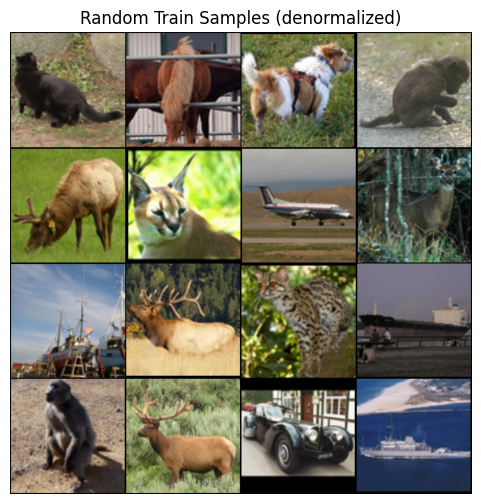

In [4]:
import matplotlib.pyplot as plt

batch_size = 64
num_workers = 2

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True)

# 샘플 이미지 16개 확인
# 역정규화 유틸
def denormalize(img_tensor, mean, std):
    # img_tensor: (C,H,W) or (B,C,H,W)
    mean = torch.tensor(mean, device=img_tensor.device).view(-1, 1, 1)
    std  = torch.tensor(std,  device=img_tensor.device).view(-1, 1, 1)
    return img_tensor * std + mean  # [6]

def show_grid(dataset, n=16, mean=mean_std_imagenet[0], std=mean_std_imagenet[1]):
    idxs = np.random.choice(len(dataset), size=n, replace=False)
    imgs, labels = zip(*[dataset[i] for i in idxs])  # transformed tensors
    imgs = torch.stack(list(imgs), dim=0)            # (B,C,H,W), 이미 Normalize 적용됨

    # 역정규화 후 클램프
    imgs_denorm = denormalize(imgs, mean, std).clamp(0, 1)  # [6][9]
    grid = utils.make_grid(imgs_denorm, nrow=int(math.sqrt(n)))  # normalize=False로 유지 [2]
    npimg = grid.cpu().permute(1, 2, 0).numpy()                # CHW -> HWC [3]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    plt.imshow(npimg)
    plt.axis('off')
    plt.title('Random Train Samples (denormalized)')
    plt.show()

# 호출
show_grid(train_ds, n=16)

학습/검증용 DataLoader 생성. 샘플 그리드를 utils.make_grid로 시각화한다.

In [5]:
# Patch Embedding: Conv2d로 (B, C, H, W) -> (B, N, D)
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224, emb_dropout=0.0):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.num_patches, emb_size))
        self.dropout = nn.Dropout(emb_dropout)

    def forward(self, x):
        # x: (B, C, H, W) -> (B, E, H/ps, W/ps) -> (B, N, E)
        x = self.proj(x)                              # (B, E, H', W')
        x = x.flatten(2).transpose(1, 2)              # (B, N, E)
        B = x.size(0)
        cls = self.cls_token.expand(B, -1, -1)        # (B, 1, E)
        x = torch.cat([cls, x], dim=1)                # (B, 1+N, E)
        x = x + self.pos_embed[:, :x.size(1)]
        return self.dropout(x)

# Multi-Head Self-Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=12, attn_dropout=0.0, proj_dropout=0.0):
        super().__init__()
        assert emb_size % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(emb_size, emb_size)
        self.proj_drop = nn.Dropout(proj_dropout)

    def forward(self, x, mask=None):
        B, N, E = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)  # (3, B, H, N, D)
        q, k, v = qkv[0], qkv[1], qkv[2] # Corrected indexing here
        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, H, N, N)
        if mask is not None:
            attn = attn.masked_fill(~mask, float('-inf'))
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        out = attn @ v                                   # (B, H, N, D)
        out = out.transpose(1, 2).reshape(B, N, E)       # (B, N, E)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out

# FFN
class FeedForward(nn.Module):
    def __init__(self, emb_size=768, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        hidden = int(emb_size * mlp_ratio)
        self.net = nn.Sequential(
            nn.Linear(emb_size, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, emb_size),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

# Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=768, num_heads=12, mlp_ratio=4.0, attn_dropout=0.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn  = MultiHeadAttention(emb_size, num_heads, attn_dropout, dropout)
        self.norm2 = nn.LayerNorm(emb_size)
        self.ffn   = FeedForward(emb_size, mlp_ratio, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

# Transformer Encoder (stack)
class TransformerEncoder(nn.Module):
    def __init__(self, depth=12, **block_kwargs):
        super().__init__()
        self.layers = nn.ModuleList([TransformerEncoderBlock(**block_kwargs) for _ in range(depth)])

    def forward(self, x):
        for blk in self.layers:
            x = blk(x)
        return x

Conv2d로 패치 단위 임베딩을 만들고, CLS 토큰과 포지셔널 임베딩을 더한다.

Multi-Head Attention, FFN(Feed Forward Network), Residual/LN(Layer Normalization)으로 Transformer Encoder 블록을 쌓는다.

In [6]:
class ClassificationHead(nn.Module):
    def __init__(self, emb_size=768, num_classes=10, use_cls_token=True, dropout=0.0):
        super().__init__()
        self.use_cls_token = use_cls_token
        self.norm = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        # x: (B, 1+N, E)
        if self.use_cls_token:
            x = x[:, 0]           # CLS
        else:
            x = x.mean(dim=1)     # mean pooling
        x = self.norm(x)
        x = self.dropout(x)
        return self.fc(x)

class ViT(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_channels=3,
        num_classes=10,
        emb_size=384,
        depth=8,
        num_heads=6,
        mlp_ratio=4.0,
        emb_dropout=0.0,
        attn_dropout=0.0,
        dropout=0.0,
        use_cls_token=True,
    ):
        super().__init__()
        self.patch = PatchEmbedding(in_channels, patch_size, emb_size, img_size, emb_dropout)
        self.encoder = TransformerEncoder(
            depth=depth,
            emb_size=emb_size,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            attn_dropout=attn_dropout,
            dropout=dropout,
        )
        self.head = ClassificationHead(emb_size, num_classes, use_cls_token=use_cls_token, dropout=dropout)

    def forward(self, x):
        x = self.patch(x)
        x = self.encoder(x)
        x = self.head(x)
        return x

# 모델 인스턴스 생성(경량 설정: STL10 소규모에 적합)
model = ViT(
    img_size=img_size,
    patch_size=16,
    in_channels=3,
    num_classes=num_classes,
    emb_size=384,
    depth=8,
    num_heads=6,
    mlp_ratio=4.0,
    emb_dropout=0.0,
    attn_dropout=0.0,
    dropout=0.1,
    use_cls_token=True,
).to(device)

print(model.__class__.__name__)


ViT


CLS 토큰만 사용하는 방식과 토큰 평균을 사용하는 방식을 토글로 제공한다. 실험 편의를 위해 드롭아웃/헤드 수/깊이 등 하이퍼파라미터를 인자로 조정 가능하게 구현한다

In [7]:
lr = 3e-4
weight_decay = 0.05
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

train_acc = MulticlassAccuracy(num_classes=num_classes).to(device)
val_acc   = MulticlassAccuracy(num_classes=num_classes).to(device)
train_f1  = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
val_f1    = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

criterion = nn.CrossEntropyLoss()


AdamW + weight decay, Cosine Annealing sched with warm restarts를 사용한다.

정확도/F1 micro는 torchmetrics로 실시간 업데이트한다.

In [14]:
def train_one_epoch(model, loader, optimizer, criterion, epoch, scaler=None):
    model.train()
    train_acc.reset(); train_f1.reset()
    running_loss = 0.0
    pbar = tqdm(loader, desc=f"Train Epoch {epoch}", leave=False)

    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        # 혼합정밀 옵션
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        train_acc.update(outputs.softmax(dim=1), targets)
        train_f1.update(outputs.softmax(dim=1), targets)

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{train_acc.compute().item():.4f}",
            "f1": f"{train_f1.compute().item():.4f}",
            "lr": f"{optimizer.param_groups[0]['lr']:.2e}" # Corrected access
        })

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = train_acc.compute().item()
    epoch_f1  = train_f1.compute().item()
    return epoch_loss, epoch_acc, epoch_f1

@torch.no_grad()
def validate(model, loader, criterion, epoch):
    model.eval()
    val_acc.reset(); val_f1.reset()
    running_loss = 0.0
    pbar = tqdm(loader, desc=f"Valid Epoch {epoch}", leave=False)
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * images.size(0)
        val_acc.update(outputs.softmax(dim=1), targets)
        val_f1.update(outputs.softmax(dim=1), targets)

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{val_acc.compute().item():.4f}",
            "f1": f"{val_f1.compute().item():.4f}",
            "lr": f"{optimizer.param_groups[0]['lr']:.2e}" # Corrected access
        })

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = val_acc.compute().item()
    epoch_f1  = val_f1.compute().item()
    return epoch_loss, epoch_acc, epoch_f1

tqdm으로 미니배치 단위 손실/정확도/F1을 갱신해 보여주고, 에폭 종료 시 총괄 지표를 출력한다.

Torchmetrics는 update/compute/reset 패턴으로 사용한다.

In [13]:
epochs = 20
best_val_acc = 0.0
best_state = None

history = []  # 각 에폭 지표 기록

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

for epoch in range(1, epochs+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_f1 = train_one_epoch(model, train_dl, optimizer, criterion, epoch, scaler=scaler)
    va_loss, va_acc, va_f1 = validate(model, val_dl, criterion, epoch)
    scheduler.step(epoch)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = copy.deepcopy(model.state_dict())

    dt = time.time() - t0
    history.append({
        "epoch": epoch,
        "train_loss": tr_loss, "train_acc": tr_acc, "train_f1": tr_f1,
        "val_loss": va_loss, "val_acc": va_acc, "val_f1": va_f1,
        "time_sec": dt,
        "lr": optimizer.param_groups[0]['lr']
    })

    print(f"[Epoch {epoch:02d}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f} | "
          f"time={dt:.1f}s lr={optimizer.param_groups[0]['lr']:.2e}")

# 베스트 모델 로드
if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, "vit_stl10_best.pth")
    print(f"Best val acc: {best_val_acc:.4f}, model saved to vit_stl10_best.pth")

/tmp/ipython-input-3953249028.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))
Train Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-2466937419.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Epoch 01] train_loss=1.6845 acc=0.3486 f1=0.3420 | val_loss=1.7143 acc=0.3562 f1=0.3247 | time=36.1s lr=2.71e-04


[Epoch 02] train_loss=1.6045 acc=0.3850 f1=0.3746 | val_loss=1.6316 acc=0.4015 f1=0.3763 | time=37.1s lr=1.97e-04


[Epoch 03] train_loss=1.5165 acc=0.4224 f1=0.4161 | val_loss=1.4412 acc=0.4536 f1=0.4419 | time=37.7s lr=1.04e-04


[Epoch 04] train_loss=1.3756 acc=0.4790 f1=0.4735 | val_loss=1.3909 acc=0.4789 f1=0.4658 | time=37.7s lr=2.96e-05


[Epoch 05] train_loss=1.2864 acc=0.5180 f1=0.5125 | val_loss=1.3554 acc=0.4983 f1=0.4898 | time=38.0s lr=3.00e-04


[Epoch 06] train_loss=1.4554 acc=0.4510 f1=0.4461 | val_loss=1.5102 acc=0.4184 f1=0.3892 | time=37.8s lr=2.93e-04


[Epoch 07] train_loss=1.3877 acc=0.4712 f1=0.4676 | val_loss=1.4448 acc=0.4557 f1=0.4495 | time=37.9s lr=2.71e-04


[Epoch 08] train_loss=1.3481 acc=0.4836 f1=0.4798 | val_loss=1.4506 acc=0.4538 f1=0.4449 | time=37.7s lr=2.38e-04


[Epoch 09] train_loss=1.2737 acc=0.5168 f1=0.5141 | val_loss=1.4089 acc=0.4890 f1=0.4773 | time=37.9s lr=1.97e-04


[Epoch 10] train_loss=1.2127 acc=0.5406 f1=0.5379 | val_loss=1.3204 acc=0.5190 f1=0.5202 | time=37.8s lr=1.50e-04


[Epoch 11] train_loss=1.1427 acc=0.5692 f1=0.5681 | val_loss=1.2845 acc=0.5328 f1=0.5240 | time=37.7s lr=1.04e-04


[Epoch 12] train_loss=1.0491 acc=0.6152 f1=0.6134 | val_loss=1.2567 acc=0.5482 f1=0.5457 | time=37.2s lr=6.26e-05


[Epoch 13] train_loss=0.9757 acc=0.6416 f1=0.6414 | val_loss=1.2419 acc=0.5560 f1=0.5455 | time=37.6s lr=2.96e-05


[Epoch 14] train_loss=0.9113 acc=0.6632 f1=0.6619 | val_loss=1.2309 acc=0.5619 f1=0.5600 | time=37.5s lr=8.32e-06


[Epoch 15] train_loss=0.8711 acc=0.6848 f1=0.6840 | val_loss=1.2246 acc=0.5688 f1=0.5668 | time=37.9s lr=3.00e-04


[Epoch 16] train_loss=1.1581 acc=0.5726 f1=0.5713 | val_loss=1.4337 acc=0.4946 f1=0.4841 | time=38.0s lr=2.98e-04


[Epoch 17] train_loss=1.1705 acc=0.5628 f1=0.5607 | val_loss=1.3671 acc=0.5020 f1=0.4885 | time=37.7s lr=2.93e-04


[Epoch 18] train_loss=1.1069 acc=0.5824 f1=0.5795 | val_loss=1.2783 acc=0.5341 f1=0.5214 | time=38.3s lr=2.84e-04


[Epoch 19] train_loss=1.0618 acc=0.6002 f1=0.5993 | val_loss=1.3824 acc=0.5060 f1=0.4893 | time=39.2s lr=2.71e-04


[Epoch 20] train_loss=1.0482 acc=0.6052 f1=0.6037 | val_loss=1.3679 acc=0.5144 f1=0.4971 | time=38.4s lr=2.56e-04
Best val acc: 0.5688, model saved to vit_stl10_best.pth


최고의 검증 정확도 모델을 저장하고, 각 에폭 로그를 표로 누적해 출력한다.

CosineAnnealingWarmRestarts는 각 에폭 끝에서 step(epoch)을 호출한다.

epoch 16 에서 acc 하락, loss 증가. Overfitting 의심.

In [15]:
import pandas as pd

df_hist = pd.DataFrame(history)
display(df_hist.style.format({
    "train_loss": "{:.4f}", "train_acc": "{:.4f}", "train_f1": "{:.4f}",
    "val_loss": "{:.4f}", "val_acc": "{:.4f}", "val_f1": "{:.4f}",
    "time_sec": "{:.1f}", "lr": "{:.2e}"
}))


,epoch,train_loss,train_acc,train_f1,val_loss,val_acc,val_f1,time_sec,lr
0,1,1.6845,0.3486,0.3420,1.7143,0.3562,0.3247,36.1,2.71e-04
1,2,1.6045,0.3850,0.3746,1.6316,0.4015,0.3763,37.1,1.97e-04
2,3,1.5165,0.4224,0.4161,1.4412,0.4536,0.4419,37.7,1.04e-04
3,4,1.3756,0.4790,0.4735,1.3909,0.4789,0.4658,37.7,2.96e-05
4,5,1.2864,0.5180,0.5125,1.3554,0.4983,0.4898,38.0,3.00e-04
5,6,1.4554,0.4510,0.4461,1.5102,0.4184,0.3892,37.8,2.93e-04
6,7,1.3877,0.4712,0.4676,1.4448,0.4557,0.4495,37.9,2.71e-04
7,8,1.3481,0.4836,0.4798,1.4506,0.4538,0.4449,37.7,2.38e-04
8,9,1.2737,0.5168,0.5141,1.4089,0.4890,0.4773,37.9,1.97e-04
9,10,1.2127,0.5406,0.5379,1.3204,0.5190,0.5202,37.8,1.50e-04


history 리스트를 pandas DataFrame으로 변환해 테이블 표시. 학습 도중 tqdm가 실시간 상태를 보여주고, 이 셀은 최종 요약 테이블을 제공한다.

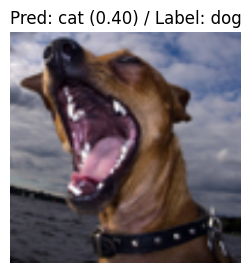

In [17]:
idx = np.random.randint(0, len(val_ds))
img, label = val_ds[idx]

model.eval()
with torch.no_grad():
    logits = model(img.unsqueeze(0).to(device))
    probs = logits.softmax(dim=1).squeeze(0).cpu()
pred = probs.argmax().item()

# STL10 클래스 이름은 datasets.STL10 객체에 classes 속성으로 포함될 수 있음
class_names = getattr(val_ds, 'classes', [str(i) for i in range(num_classes)])

plt.figure(figsize=(3,3))
# Normalize 역변환 시각화(대략)
show_img = img.clone().cpu()
show_img = show_img * torch.tensor(mean_std_imagenet[1]).view(3,1,1) + torch.tensor(mean_std_imagenet[0]).view(3,1,1)
show_img = torch.clamp(show_img, 0, 1)
plt.imshow(show_img.permute(1,2,0).numpy())
plt.axis('off')
plt.title(f"Pred: {class_names[pred]} ({probs[pred]:.2f}) / Label: {class_names[label]}")
plt.show()

검증 세트에서 임의 샘플을 선택해 예측 클래스와 확률을 확인한다.

성능이 좋지 않은 이유는 :

적은 데이터셋,

Inductive bias 등의 이유가 있을 수 있다.

모델 크기와 데이터 양의 밸런스를 맞추기 위해 emb_size/heads/depth를 조정하거나, 패치 크기를 키워 토큰 수를 줄일 수 있다. 공개 구현에서 하이퍼파라미터 선택이 성능/속도에 영향을 준다고 설명되어 있다.

데이터: torchvision STL-10은 자동 다운로드로 바로 사용되며, 문서/소스에 split과 원격 URL이 명시되어 신뢰할 수 있다.

모델: ViT는 이미지를 패치 시퀀스로 보고 Transformer Encoder로 처리한다. Conv2d 기반 패치 투영과 CLS 토큰 전략이 구현을 단순화한다. 하이퍼파라미터(임베딩 차원/헤드/깊이/드롭아웃)는 성능-속도-메모리 절충을 만든다.

로깅: tqdm로 배치별 진행을 시각화하고, torchmetrics로 정확도/F1을 실시간 집계한다. 학습 후 pandas 테이블로 에폭별 결과를 정리해 재현성 및 비교가 쉽다.

## 더 경량 모델 학습(ViT-Tiny 스타일)

In [25]:
# 더 경량(Tiny 스타일) 모델 설정
tiny_cfg = dict(
    img_size=224, patch_size=16, in_channels=3, num_classes=10,
    emb_size=256, depth=6, num_heads=4, mlp_ratio=4.0,
    emb_dropout=0.0, attn_dropout=0.0, dropout=0.1, use_cls_token=True
)

tiny_model = ViT(**tiny_cfg).to(device)

# 옵티마이저/스케줄러/메트릭 새로 만들기 (독립 실행)
tiny_optimizer = optim.AdamW(tiny_model.parameters(), lr=3e-4, weight_decay=0.05)
tiny_scheduler = CosineAnnealingWarmRestarts(tiny_optimizer, T_0=5, T_mult=2, eta_min=1e-6)

tiny_train_acc = MulticlassAccuracy(num_classes=10).to(device)
tiny_val_acc   = MulticlassAccuracy(num_classes=10).to(device)
tiny_train_f1  = MulticlassF1Score(num_classes=10, average='macro').to(device)
tiny_val_f1    = MulticlassF1Score(num_classes=10, average='macro').to(device)
tiny_criterion = nn.CrossEntropyLoss()

def tiny_train_one_epoch(model, loader, optimizer, criterion, epoch, scaler=None):
    model.train()
    tiny_train_acc.reset(); tiny_train_f1.reset()
    running_loss = 0.0
    pbar = tqdm(loader, desc=f"[Tiny] Train {epoch}", leave=False)
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * images.size(0)
        tiny_train_acc.update(outputs.softmax(dim=1), targets)
        tiny_train_f1.update(outputs.softmax(dim=1), targets)
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{tiny_train_acc.compute().item():.4f}",
            "f1": f"{tiny_train_f1.compute().item():.4f}",
            "lr": f"{optimizer.param_groups[0]['lr']:.2e}" # Corrected access
        })
    return running_loss / len(loader.dataset), tiny_train_acc.compute().item(), tiny_train_f1.compute().item()

@torch.no_grad()
def tiny_validate(model, loader, criterion, epoch):
    model.eval()
    tiny_val_acc.reset(); tiny_val_f1.reset()
    running_loss = 0.0
    pbar = tqdm(loader, desc=f"[Tiny] Valid {epoch}", leave=False)
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * images.size(0)
        tiny_val_acc.update(outputs.softmax(dim=1), targets)
        tiny_val_f1.update(outputs.softmax(dim=1), targets)
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{tiny_val_acc.compute().item():.4f}",
            "f1": f"{tiny_val_f1.compute().item():.4f}",
            "lr": f"{optimizer.param_groups[0]['lr']:.2e}" # Corrected access
        })
    return running_loss / len(loader.dataset), tiny_val_acc.compute().item(), tiny_val_f1.compute().item()

# 학습 실행
tiny_epochs = 20
tiny_best_acc, tiny_best_state = 0.0, None
tiny_history = []
tiny_scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

for epoch in range(1, tiny_epochs+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_f1 = tiny_train_one_epoch(tiny_model, train_dl, tiny_optimizer, tiny_criterion, epoch, scaler=tiny_scaler)
    va_loss, va_acc, va_f1 = tiny_validate(tiny_model, val_dl, tiny_criterion, epoch)
    tiny_scheduler.step(epoch)
    if va_acc > tiny_best_acc:
        tiny_best_acc = va_acc
        tiny_best_state = copy.deepcopy(tiny_model.state_dict())
    dt = time.time() - t0
    tiny_history.append(dict(epoch=epoch, train_loss=tr_loss, train_acc=tr_acc, train_f1=tr_f1,
                             val_loss=va_loss, val_acc=va_acc, val_f1=va_f1, time_sec=dt,
                             lr=tiny_optimizer.param_groups[0]['lr'])) # Corrected access
    print(f"[Tiny][{epoch:02d}] train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f} | "
          f"time={dt:.1f}s lr={tiny_optimizer.param_groups[0]['lr']:.2e}") # Corrected access

if tiny_best_state is not None:
    tiny_model.load_state_dict(tiny_best_state)
    torch.save(tiny_best_state, "vit_tiny_stl10_best.pth")
    print(f"[Tiny] Best val acc: {tiny_best_acc:.4f} (saved vit_tiny_stl10_best.pth)")

import pandas as pd
display(pd.DataFrame(tiny_history).style.format({
    "train_loss":"{:.4f}","train_acc":"{:.4f}","train_f1":"{:.4f}",
    "val_loss":"{:.4f}","val_acc":"{:.4f}","val_f1":"{:.4f}",
    "time_sec":"{:.1f}","lr":"{:.2e}"
}))

/tmp/ipython-input-477551576.py:78: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  tiny_scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))
[Tiny] Train 1:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-477551576.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Tiny][01] train_loss=2.0649 acc=0.2318 f1=0.2159 | val_loss=1.9016 acc=0.2605 f1=0.1929 | time=29.6s lr=2.71e-04


[Tiny][02] train_loss=1.8269 acc=0.2906 f1=0.2797 | val_loss=1.7812 acc=0.3275 f1=0.2895 | time=30.9s lr=1.97e-04


[Tiny][03] train_loss=1.6593 acc=0.3556 f1=0.3461 | val_loss=1.6469 acc=0.3585 f1=0.3359 | time=30.4s lr=1.04e-04


[Tiny][04] train_loss=1.5577 acc=0.3946 f1=0.3881 | val_loss=1.5509 acc=0.3978 f1=0.3696 | time=29.5s lr=2.96e-05


[Tiny][05] train_loss=1.4932 acc=0.4254 f1=0.4164 | val_loss=1.4953 acc=0.4275 f1=0.4041 | time=31.2s lr=3.00e-04


[Tiny][06] train_loss=1.5900 acc=0.3968 f1=0.3873 | val_loss=1.6353 acc=0.3791 f1=0.3609 | time=30.0s lr=2.93e-04


[Tiny][07] train_loss=1.5270 acc=0.4256 f1=0.4190 | val_loss=1.4779 acc=0.4360 f1=0.4239 | time=29.7s lr=2.71e-04


[Tiny][08] train_loss=1.4270 acc=0.4696 f1=0.4633 | val_loss=1.4290 acc=0.4615 f1=0.4493 | time=30.3s lr=2.38e-04


[Tiny][09] train_loss=1.3646 acc=0.4892 f1=0.4838 | val_loss=1.3978 acc=0.4751 f1=0.4666 | time=29.5s lr=1.97e-04


[Tiny][10] train_loss=1.2966 acc=0.5130 f1=0.5090 | val_loss=1.3991 acc=0.4745 f1=0.4691 | time=31.5s lr=1.50e-04


[Tiny][11] train_loss=1.2392 acc=0.5298 f1=0.5257 | val_loss=1.3079 acc=0.5084 f1=0.5078 | time=30.9s lr=1.04e-04


[Tiny][12] train_loss=1.1685 acc=0.5602 f1=0.5561 | val_loss=1.3125 acc=0.5151 f1=0.5069 | time=29.6s lr=6.26e-05


[Tiny][13] train_loss=1.1127 acc=0.5906 f1=0.5878 | val_loss=1.2640 acc=0.5386 f1=0.5363 | time=29.5s lr=2.96e-05


[Tiny][14] train_loss=1.0581 acc=0.6100 f1=0.6089 | val_loss=1.2328 acc=0.5517 f1=0.5509 | time=30.6s lr=8.32e-06


[Tiny][15] train_loss=1.0253 acc=0.6172 f1=0.6145 | val_loss=1.2260 acc=0.5549 f1=0.5544 | time=29.8s lr=3.00e-04


[Tiny][16] train_loss=1.2082 acc=0.5462 f1=0.5439 | val_loss=1.3850 acc=0.4929 f1=0.4821 | time=29.8s lr=2.98e-04


[Tiny][17] train_loss=1.2409 acc=0.5398 f1=0.5372 | val_loss=1.3599 acc=0.5075 f1=0.4948 | time=30.3s lr=2.93e-04


[Tiny][18] train_loss=1.1826 acc=0.5590 f1=0.5570 | val_loss=1.3387 acc=0.5025 f1=0.4969 | time=29.5s lr=2.84e-04


[Tiny][19] train_loss=1.1652 acc=0.5596 f1=0.5575 | val_loss=1.3022 acc=0.5171 f1=0.5082 | time=29.8s lr=2.71e-04


[Tiny][20] train_loss=1.1045 acc=0.5882 f1=0.5855 | val_loss=1.2900 acc=0.5310 f1=0.5297 | time=30.6s lr=2.56e-04
[Tiny] Best val acc: 0.5549 (saved vit_tiny_stl10_best.pth)


,epoch,train_loss,train_acc,train_f1,val_loss,val_acc,val_f1,time_sec,lr
0,1,2.0649,0.2318,0.2159,1.9016,0.2605,0.1929,29.6,2.71e-04
1,2,1.8269,0.2906,0.2797,1.7812,0.3275,0.2895,30.9,1.97e-04
2,3,1.6593,0.3556,0.3461,1.6469,0.3585,0.3359,30.4,1.04e-04
3,4,1.5577,0.3946,0.3881,1.5509,0.3978,0.3696,29.5,2.96e-05
4,5,1.4932,0.4254,0.4164,1.4953,0.4275,0.4041,31.2,3.00e-04
5,6,1.5900,0.3968,0.3873,1.6353,0.3791,0.3609,30.0,2.93e-04
6,7,1.5270,0.4256,0.4190,1.4779,0.4360,0.4239,29.7,2.71e-04
7,8,1.4270,0.4696,0.4633,1.4290,0.4615,0.4493,30.3,2.38e-04
8,9,1.3646,0.4892,0.4838,1.3978,0.4751,0.4666,29.5,1.97e-04
9,10,1.2966,0.5130,0.5090,1.3991,0.4745,0.4691,31.5,1.50e-04


소형 GPU/빠른 실험용. 임베딩 192 ~ 256, 헤드 3 ~ 4, 깊이 6~10 정도가 관례에 부합한다. 여기서는 emb=256, heads=4, depth=6을 사용한다.

성능이 비슷하다.

## 더 강력 모델 학습(ViT-Small/Base 사이)

In [27]:
# 더 강력(Small~Base 사이) 모델 설정
strong_cfg = dict(
    img_size=224, patch_size=16, in_channels=3, num_classes=10,
    emb_size=512, depth=10, num_heads=8, mlp_ratio=4.0,
    emb_dropout=0.0, attn_dropout=0.0, dropout=0.1, use_cls_token=True
)

strong_model = ViT(**strong_cfg).to(device)

# 옵티마이저/스케줄러/메트릭 새로 만들기
strong_optimizer = optim.AdamW(strong_model.parameters(), lr=3e-4, weight_decay=0.05)
strong_scheduler = CosineAnnealingWarmRestarts(strong_optimizer, T_0=5, T_mult=2, eta_min=1e-6)

strong_train_acc = MulticlassAccuracy(num_classes=10).to(device)
strong_val_acc   = MulticlassAccuracy(num_classes=10).to(device)
strong_train_f1  = MulticlassF1Score(num_classes=10, average='macro').to(device)
strong_val_f1    = MulticlassF1Score(num_classes=10, average='macro').to(device)
strong_criterion = nn.CrossEntropyLoss()

def strong_train_one_epoch(model, loader, optimizer, criterion, epoch, scaler=None):
    model.train()
    strong_train_acc.reset(); strong_train_f1.reset()
    running_loss = 0.0
    pbar = tqdm(loader, desc=f"[Strong] Train {epoch}", leave=False)
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * images.size(0)
        strong_train_acc.update(outputs.softmax(dim=1), targets)
        strong_train_f1.update(outputs.softmax(dim=1), targets)
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{strong_train_acc.compute().item():.4f}",
            "f1": f"{strong_train_f1.compute().item():.4f}",
            "lr": f"{optimizer.param_groups[0]['lr']:.2e}"
        })
    return running_loss / len(loader.dataset), strong_train_acc.compute().item(), strong_train_f1.compute().item()

@torch.no_grad()
def strong_validate(model, loader, criterion, epoch):
    model.eval()
    strong_val_acc.reset(); strong_val_f1.reset()
    running_loss = 0.0
    pbar = tqdm(loader, desc=f"[Strong] Valid {epoch}", leave=False)
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * images.size(0)
        strong_val_acc.update(outputs.softmax(dim=1), targets)
        strong_val_f1.update(outputs.softmax(dim=1), targets)
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{strong_val_acc.compute().item():.4f}",
            "f1": f"{strong_val_f1.compute().item():.4f}",
        })
    return running_loss / len(loader.dataset), strong_val_acc.compute().item(), strong_val_f1.compute().item()

# 학습 실행
strong_epochs = 20
strong_best_acc, strong_best_state = 0.0, None
strong_history = []
strong_scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

for epoch in range(1, strong_epochs+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_f1 = strong_train_one_epoch(strong_model, train_dl, strong_optimizer, strong_criterion, epoch, scaler=strong_scaler)
    va_loss, va_acc, va_f1 = strong_validate(strong_model, val_dl, strong_criterion, epoch)
    strong_scheduler.step(epoch)
    if va_acc > strong_best_acc:
        strong_best_acc = va_acc
        strong_best_state = copy.deepcopy(strong_model.state_dict())
    dt = time.time() - t0
    strong_history.append(dict(epoch=epoch, train_loss=tr_loss, train_acc=tr_acc, train_f1=tr_f1,
                               val_loss=va_loss, val_acc=va_acc, val_f1=va_f1, time_sec=dt,
                               lr=strong_optimizer.param_groups[0]['lr']))
    print(f"[Strong][{epoch:02d}] train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f} | "
          f"time={dt:.1f}s lr={strong_optimizer.param_groups[0]['lr']:.2e}")

if strong_best_state is not None:
    strong_model.load_state_dict(strong_best_state)
    torch.save(strong_best_state, "vit_strong_stl10_best.pth")
    print(f"[Strong] Best val acc: {strong_best_acc:.4f} (saved vit_strong_stl10_best.pth)")

import pandas as pd
display(pd.DataFrame(strong_history).style.format({
    "train_loss":"{:.4f}","train_acc":"{:.4f}","train_f1":"{:.4f}",
    "val_loss":"{:.4f}","val_acc":"{:.4f}","val_f1":"{:.4f}",
    "time_sec":"{:.1f}","lr":"{:.2e}"
}))

/tmp/ipython-input-3229953042.py:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  strong_scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))
[Strong] Train 1:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-3229953042.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Strong][01] train_loss=2.2185 acc=0.2210 f1=0.2106 | val_loss=2.1884 acc=0.2084 f1=0.1439 | time=60.6s lr=2.71e-04


[Strong][02] train_loss=1.9207 acc=0.2718 f1=0.2563 | val_loss=1.8945 acc=0.2858 f1=0.2369 | time=63.3s lr=1.97e-04


[Strong][03] train_loss=1.7221 acc=0.3274 f1=0.3164 | val_loss=1.6673 acc=0.3511 f1=0.3268 | time=64.8s lr=1.04e-04


[Strong][04] train_loss=1.5860 acc=0.3868 f1=0.3794 | val_loss=1.5268 acc=0.4129 f1=0.4035 | time=65.1s lr=2.96e-05


[Strong][05] train_loss=1.4900 acc=0.4278 f1=0.4210 | val_loss=1.4911 acc=0.4268 f1=0.4138 | time=66.2s lr=3.00e-04


[Strong][06] train_loss=1.6312 acc=0.3762 f1=0.3713 | val_loss=1.6387 acc=0.3558 f1=0.3241 | time=64.7s lr=2.93e-04


[Strong][07] train_loss=1.5809 acc=0.3862 f1=0.3793 | val_loss=1.5351 acc=0.4033 f1=0.3808 | time=65.3s lr=2.71e-04


[Strong][08] train_loss=1.4899 acc=0.4230 f1=0.4184 | val_loss=1.5715 acc=0.3857 f1=0.3412 | time=65.3s lr=2.38e-04


[Strong][09] train_loss=1.4557 acc=0.4432 f1=0.4389 | val_loss=1.5229 acc=0.4230 f1=0.3948 | time=64.9s lr=1.97e-04


[Strong][10] train_loss=1.3591 acc=0.4892 f1=0.4840 | val_loss=1.4084 acc=0.4770 f1=0.4715 | time=65.0s lr=1.50e-04


[Strong][11] train_loss=1.2628 acc=0.5254 f1=0.5222 | val_loss=1.3701 acc=0.4850 f1=0.4811 | time=65.2s lr=1.04e-04


[Strong][12] train_loss=1.1935 acc=0.5508 f1=0.5483 | val_loss=1.3212 acc=0.5128 f1=0.5036 | time=65.2s lr=6.26e-05


[Strong][13] train_loss=1.1304 acc=0.5680 f1=0.5652 | val_loss=1.2870 acc=0.5165 f1=0.5195 | time=65.4s lr=2.96e-05


[Strong][14] train_loss=1.0609 acc=0.5988 f1=0.5976 | val_loss=1.2593 acc=0.5343 f1=0.5324 | time=64.8s lr=8.32e-06


[Strong][15] train_loss=1.0098 acc=0.6208 f1=0.6196 | val_loss=1.2425 acc=0.5440 f1=0.5395 | time=64.8s lr=3.00e-04


[Strong][16] train_loss=1.3193 acc=0.5050 f1=0.5026 | val_loss=1.4166 acc=0.4746 f1=0.4501 | time=64.9s lr=2.98e-04


[Strong][17] train_loss=1.2586 acc=0.5316 f1=0.5295 | val_loss=1.3804 acc=0.4821 f1=0.4707 | time=64.7s lr=2.93e-04


[Strong][18] train_loss=1.2581 acc=0.5350 f1=0.5321 | val_loss=1.4331 acc=0.4766 f1=0.4653 | time=64.9s lr=2.84e-04


[Strong][19] train_loss=1.2195 acc=0.5484 f1=0.5454 | val_loss=1.3660 acc=0.5082 f1=0.5098 | time=64.6s lr=2.71e-04


[Strong][20] train_loss=1.2123 acc=0.5476 f1=0.5468 | val_loss=1.3995 acc=0.4841 f1=0.4647 | time=64.7s lr=2.56e-04
[Strong] Best val acc: 0.5440 (saved vit_strong_stl10_best.pth)


,epoch,train_loss,train_acc,train_f1,val_loss,val_acc,val_f1,time_sec,lr
0,1,2.2185,0.2210,0.2106,2.1884,0.2084,0.1439,60.6,2.71e-04
1,2,1.9207,0.2718,0.2563,1.8945,0.2858,0.2369,63.3,1.97e-04
2,3,1.7221,0.3274,0.3164,1.6673,0.3511,0.3268,64.8,1.04e-04
3,4,1.5860,0.3868,0.3794,1.5268,0.4129,0.4035,65.1,2.96e-05
4,5,1.4900,0.4278,0.4210,1.4911,0.4268,0.4138,66.2,3.00e-04
5,6,1.6312,0.3762,0.3713,1.6387,0.3558,0.3241,64.7,2.93e-04
6,7,1.5809,0.3862,0.3793,1.5351,0.4033,0.3808,65.3,2.71e-04
7,8,1.4899,0.4230,0.4184,1.5715,0.3857,0.3412,65.3,2.38e-04
8,9,1.4557,0.4432,0.4389,1.5229,0.4230,0.3948,64.9,1.97e-04
9,10,1.3591,0.4892,0.4840,1.4084,0.4770,0.4715,65.0,1.50e-04


compute가 더 큰 환경에서 성능을 높이기 위한 구성. 관례적으로 Small=emb 384/heads 6/depth 12, Base=emb 768/heads 12/depth 12가 널리 쓰인다.

여기서는 계산량과 STL-10 데이터 크기를 감안해 emb=512, heads=8, depth=10으로 절충했다.

Tiny/Small/Base 등의 스케일링은 임베딩 차원과 헤드 수가 함께 증가하도록 설계되는 것이 보편적이며, 헤드 수는 보통 임베딩 차원을 균등 분할하도록 선택된다(예: 256/4=64, 512/8=64).

AMP(autocast+GradScaler)는 학습 속도를 높이고 메모리 사용량을 줄이는 데 유용하며, PyTorch 가이드라인대로 scaler.scale/backward/step/update 순서를 지키면 된다.